# Exercise 7: Denoising Diffusion Probabilistic Models

Submitted by:

 ** Faisal Omari 325616894

 ** Fadi Khatib 308052992

### Load libraries and utils

In [42]:
## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam

import numpy as np
import math

import os

# Visualization tools
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError: # Google Colab does not have PyTorch Lightning installed by default. Hence, we do it here if necessary
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

Seed set to 42


Using device cuda:0


In [43]:
def show_tensor_image(img):
    reverse_transforms = transforms.Compose([
        transforms.Lambda(lambda t: (t + 1) / 2),
        transforms.Lambda(lambda t: torch.minimum(torch.tensor([1]), t)),
        transforms.Lambda(lambda t: torch.maximum(torch.tensor([0]), t)),
        transforms.ToPILImage(),
    ])
    plt.imshow(reverse_transforms(img))

def trim_imgs(imgs, skip=10):
    imgs = imgs.view((-1,) + imgs.shape[2:])        # BATCH * T, CH, WIDTH, HEIGHT
    imgs = imgs[::skip]
    return imgs

### Load MNIST

In [44]:
IMG_SIZE = 28
IMG_CH = 1
BATCH_SIZE = 128

def load_MNIST(data_transform, train=True):
    return torchvision.datasets.MNIST(
        "./",
        download=True,
        train=train,
        transform=data_transform,
    )


def load_transformed_MNIST():
    data_transforms = [
        transforms.Resize((IMG_SIZE, IMG_SIZE)),
        transforms.ToTensor(),  # Scales data into [0,1]
        transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
    ]

    data_transform = transforms.Compose(data_transforms)
    train_set = load_MNIST(data_transform, train=True)
    test_set = load_MNIST(data_transform, train=False)
    return train_set, test_set

train, test = load_transformed_MNIST()
train_dataloader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=False, drop_last=True)

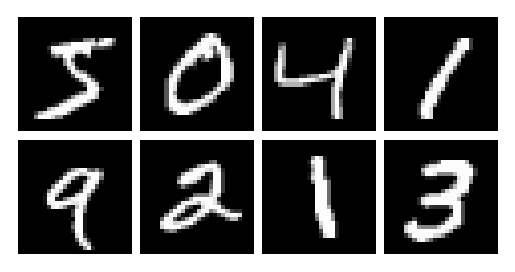

In [45]:
def show_imgs(imgs, nrows=1, grid=True):
    ncols = len(imgs) // nrows

    imgs = torch.stack(imgs) if isinstance(imgs, list) else imgs
    imgs = imgs.unsqueeze(1) if imgs.dim() == 3 else imgs

    if grid:
        grid = torchvision.utils.make_grid(imgs.cpu(), nrow=ncols, pad_value=128)
        show_tensor_image(grid.detach().cpu())
    else:
        ncols = len(imgs) // nrows
        for idx, img in enumerate(imgs):
            plt.subplot(nrows, ncols, idx + 1)
            plt.axis('off')
            show_tensor_image(img.detach().cpu())

    plt.axis('off')
    plt.show()
    plt.close()

show_imgs([train[i][0] for i in range(8)], nrows=2)

## Define the architercture

<img width="70%" src="https://sharon.srworkspace.com/dgm/time.png"/>

In [46]:
#@title Net components

class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.ReLU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        #x = x[:, None]
        return self.model(x)

class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.Conv2d(in_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

    def forward(self, x):
        return self.model(x)

class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs):
        super().__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(2 * in_chs, out_chs, 3, 2, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU(),
            nn.Conv2d(out_chs, out_chs, 3, 1, 1),
            nn.BatchNorm2d(out_chs),
            nn.ReLU()
        )

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x

In [47]:
class UNet(nn.Module):
    def __init__(self, T):
        super(UNet, self).__init__()
        self.T = T

        img_chs = IMG_CH
        down_chs = (64, 128, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        self.latent_image_size = IMG_SIZE // 4 # Store this as an instance variable

        # New
        t_embed_dim = 8

        # Initial convolution
        self.down0 = nn.Sequential(
            nn.Conv2d(img_chs, down_chs[0], 3, padding=1),
            nn.BatchNorm2d(down_chs[0]),
            nn.ReLU()
        )

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1])
        self.down2 = DownBlock(down_chs[1], down_chs[2])
        self.to_vec = nn.Sequential(nn.Flatten(), nn.ReLU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * self.latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * self.latent_image_size**2),
            nn.ReLU()
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim) # New
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[0]) # New
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[1]) # New

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], self.latent_image_size, self.latent_image_size)),
            nn.Conv2d(up_chs[0], up_chs[0], 3, padding=1),
            nn.BatchNorm2d(up_chs[0]),
            nn.ReLU(),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1])
        self.up2 = UpBlock(up_chs[1], up_chs[2])

        # Match output channels
        self.out = nn.Sequential(
            nn.Conv2d(up_chs[2] + down_chs[0], up_chs[2], 3, 1, 1),
            nn.BatchNorm2d(up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], img_chs, 3, 1, 1)
        )

        print("Net Num params: ", sum(p.numel() for p in self.parameters()))

    def forward(self, x, t):
        # Initial downsampling
        down0 = self.down0(x)
        down1 = self.down1(down0)
        down2 = self.down2(down1)
        latent_vec = self.to_vec(down2)
        
        # Embed the timestep
        t = t.float() / self.T
        t_emb = self.sinusoidaltime(t)
        
        latent_vec = self.dense_emb(latent_vec)
        temb_1 = self.temb_1(t_emb)
        temb_2 = self.temb_2(t_emb)
        
        # Upsampling
        up0 = self.up0(latent_vec.view(latent_vec.size(0), -1, self.latent_image_size, self.latent_image_size))
        up1 = self.up1(up0 + temb_1[:, :, None, None], down2)
        up2 = self.up2(up1 + temb_2[:, :, None, None], down1)
        
        # Concatenate the initial downsampling output for the final layer
        return self.out(torch.cat((up2, down0), dim=1))

## Define DDPM model

A fundemantal idea of diffusion models is to add a little noise to the image each time step and learn how to remove it, depending on time. Here, we will use variance schedule.

<img width="70%" src="https://sharon.srworkspace.com/dgm/dog.png"/>

In [48]:
class DDPM(pl.LightningModule):
    def __init__(self, T=1000, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon=0.008
        if method == 'cosine':
            steps=torch.linspace(0,T,steps=T+1).to(device)
            f_t=torch.cos(((steps/T+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
            self.Beta = torch.clip(1.0-f_t[1:]/f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.net = UNet(T)

        # Logging
        self.train_loss = []
        self.train_loss_in_epoch = []

        self.validation_loss = []
        self.validation_loss_in_epoch = []

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        # Implement here
        noise = torch.randn_like(x_0).to(x_0.device)
        mean = torch.sqrt(self.a_bar[t])[:, None, None, None] * x_0
        std = torch.sqrt(1 - self.a_bar[t])[:, None, None, None] * noise
        return mean + std, noise

    # To be used later
    def get_x0_pred(self, x_t, t, e_t):
        x_0_pred = (x_t - torch.sqrt(1 - self.a_bar[t]) * e_t) / torch.sqrt(self.a_bar[t])
        x_0_pred.clamp_(-1, 1)
        return x_0_pred

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        # Implement here
        coeff = (self.Beta[t] / torch.sqrt(1 - self.a_bar[t]))[:, None, None, None]
        mean = (x_t - coeff * e_t) / torch.sqrt(self.a[t])[:, None, None, None]
        std = torch.sqrt(self.Beta[t])[:, None, None, None]
        return mean + std * torch.randn_like(x_t).to(x_t.device)

    def get_loss(self, x_0, t):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        # Implement here
        noise = torch.randn_like(x_0).to(x_0.device)
        x_t, _ = self.q(x_0, t)
        e_t = self.net(x_t, t)
        return F.mse_loss(noise, e_t)

    @torch.no_grad()
    def sample(self, num_imgs=1):
        output = torch.zeros((num_imgs, self.T, IMG_CH, IMG_SIZE, IMG_SIZE))  # For each image, save all the timesteps
        x_t = torch.randn((num_imgs, IMG_CH, IMG_SIZE, IMG_SIZE)).to(device)
        for t in reversed(range(self.T)):
            e_t = self.net(x_t, torch.tensor([t] * num_imgs, device=device))
            x_t = self.reverse_q(x_t, torch.tensor([t] * num_imgs, device=device), e_t)
            output[:, t] = x_t
        return output

    # Lightning Configurations
    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-3)

    def training_step(self, batch, batch_idx):
        x = batch[0].to(device)
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t)
        self.train_loss_in_epoch.append(loss.item())
        return loss

    def validation_step(self, batch, batch_idx):
        x = batch[0].to(device)
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t)
        self.validation_loss_in_epoch.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.tensor(self.train_loss_in_epoch).mean()
        self.train_loss_in_epoch = []

        self.log("train_loss", avg_loss, prog_bar=True)
        self.train_loss.append(avg_loss.detach().item())

        print(f"Epoch {self.current_epoch} | Loss: {avg_loss.detach().item()} ")

    def on_validation_epoch_end(self):
        avg_loss = torch.tensor(self.validation_loss_in_epoch).mean()
        self.validation_loss_in_epoch = []

        self.log("val_loss", avg_loss, prog_bar=True)
        self.validation_loss.append(avg_loss.detach().item())

        sampled_data = trim_imgs(self.sample(), skip=100)
        show_imgs(sampled_data, grid=False)


Net Num params:  3032449


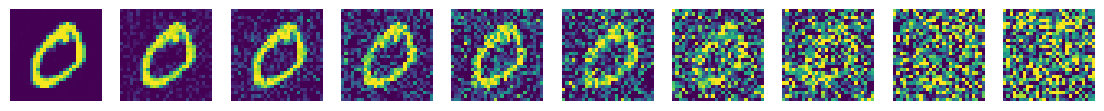

In [49]:
#@title you may run this to make sure your implementation for q is good

x_0 = train[1][0].to(device)  # Initial image
plt.figure(figsize=(14, 8))

T=1000
ddpm = DDPM(T)

for t in range(T):
    t_tenser = torch.Tensor([t]).type(torch.int64)
    x_t, noise = ddpm.q(x_0, t_tenser)
    img = torch.squeeze(x_t).cpu()
    if t % 100 == 0:
      ax = plt.subplot(1, 10, t // 100 + 1)
      ax.axis('off')
      show_tensor_image(img)

## Train

In [50]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join("DDPM"),
        devices=1,
        max_epochs=20,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_loss"),
            LearningRateMonitor("epoch")
        ]
    )

    model = DDPM(**kwargs)
    model.train()
    trainer.fit(model, train_dataloader, test_dataloader)
    model.eval()
    return model

model = train_model(T=1000).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name | Type | Params | Mode 
--------------------------------------
0 | net  | UNet | 3.0 M  | train
--------------------------------------
3.0 M     Trainable params
0         Non-trainable params
3.0 M     Total params
12.130    Total estimated model params size (MB)


Net Num params:  3032449


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

NameError: name 'latent_image_size' is not defined

In [ ]:
pl.seed_everything(1)
sampled_data = model.sample(16)[:, -1]               # Get the last time step for each image
show_imgs(sampled_data, nrows=4, grid=True)

## Autocomplete two images

In [ ]:
def complete_image(y=None, ymask=None, scale=1.):
    # Implement here
    # Hint: Use ddpm.get_x0_pred(x_t, t, e_t)

# Bonus - Adding context
<font color='red'>If you did the bonus, write it here</font><br/>

MNIST is boring! Moreover, what is the point of generating samples without controling them? <br/>
We will use a pretrained CLIP (Contrastive Language-Image Pre-Training). Given text, creates embedding. Our goal is to align image description and text embedding to each other.

In [ ]:
!pip install --quiet git+https://github.com/openai/CLIP.git

import glob
import csv
from textwrap import wrap

import clip

from PIL import Image
import numpy as np

# Setting the seed
pl.seed_everything(42)

## Load data
Go to your <a href="https://www.kaggle.com/">Kaggle</a> account and under the settings, generate new API token. <br/>
This will export you a json file, which you will upload here.

In [ ]:
# The script expects you to upload JSON file to it!

! pip install -q kaggle
from google.colab import files
files.upload()
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets list
! kaggle datasets download jessicali9530/celeba-dataset
! unzip -q celeba-dataset.zip -d faces

In [ ]:
FACES_PATH = "/content/faces/img_align_celeba/img_align_celeba"

for i in range(1,9):
  img = Image.open(f'{FACES_PATH}/00000{i}.jpg')
  plt.subplot(2, 4, i)
  plt.axis('off')
  plt.imshow(img)

plt.show()

## load pretrained model

In [ ]:
clip.available_models()

In [ ]:
clip_model, clip_preprocess = clip.load("ViT-B/32")
clip_model.eval()
CLIP_FEATURES = 512

## Intro to CLIP

Load image using CLIP

In [ ]:
img = Image.open(f'{FACES_PATH}/000001.jpg')

clip_imgs = torch.tensor(np.stack([clip_preprocess(img)])).to(device)
print("After image clip preprocessing the size is ", clip_imgs.size())

Feature extractor of CLIP

In [ ]:
clip_img_encoding = clip_model.encode_image(clip_imgs)
print(clip_img_encoding.size())

Now, we want to see how to tokenize text and encoder it using clip

In [ ]:
text_list = [
    "An Angry man",
    "Smiling bald person",
    "Happy beautiful woman"
]
text_tokens = clip.tokenize(text_list).to(device)
print("Text tokens")
print(text_tokens[:,:10])
print("----------------------------")

clip_text_encodings = clip_model.encode_text(text_tokens).float()
print("For each text, encoding of 512 features ", clip_text_encodings.size())
print(clip_text_encodings)

In order to see which one of our text descriptions best describes the daisy, we can calculate the cosine similarity between the text encodings and the image encodings. <br/>
We will load three flowers, give each its encoding and will compare to the texts above

In [ ]:
def get_img_encodings(imgs):
    processed_imgs = [clip_preprocess(img) for img in imgs]
    clip_imgs = torch.tensor(np.stack(processed_imgs)).to(device)
    clip_img_encodings = clip_model.encode_image(clip_imgs)
    return clip_img_encodings

imgs = [Image.open(f"{FACES_PATH}/{i}.jpg") for i in ["000069", "000174", "000154"]]
for i, img in enumerate(imgs):
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(img)

In [ ]:
clip_img_encodings = get_img_encodings(imgs)    # torch.Tensor([3, 512])

text_list = [
    "A surprised man with black hair",
    "A woman smiling with red hair",
    "A person with black glasses and wears black hat"
]

text_tokens = clip.tokenize(text_list).to(device)
clip_text_encodings = clip_model.encode_text(text_tokens)   # torch.Tensor([3, 512])

clip_img_encodings /= clip_img_encodings.norm(dim=-1, keepdim=True)
clip_text_encodings /= clip_text_encodings.norm(dim=-1, keepdim=True)

similarity = clip_img_encodings @ clip_text_encodings.T

print(similarity)

Well, is there a match?

In [ ]:
fig = plt.figure(figsize=(10, 10))
gs = fig.add_gridspec(2, 3, wspace=.1, hspace=0)

ax = fig.add_subplot(gs[1, :])
plt.imshow(similarity.detach().cpu().numpy().T, vmin=0.1, vmax=0.3)

labels = [ '\n'.join(wrap(text, 20)) for text in text_list ]
plt.yticks(range(len(text_tokens)), labels, fontsize=10)
plt.xticks([])

for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[x, y]:.2f}", ha="center", va="center", size=12)

Collabory: CLIP gives the most similar encoding of image to the most similar encoding of text.
Hence, we will train using the image encoding, but create new images using an encoding of text, hopefully it will work

## Proccess the data using clip

In [ ]:
IMG_SIZE = 32
IMG_CH = 3
BATCH_SIZE = 128
CLIP_FEATURES = 512

def crop_face(sample):
  return sample[:, 9:(9+32),4:(4+32)]

pre_transforms = transforms.Compose([
    transforms.Resize((50, 40)),
    transforms.ToTensor(),  # Scales data into [0,1]
    crop_face,
    transforms.Lambda(lambda t: (t * 2) - 1)  # Scale between [-1, 1]
])

random_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
])

With our current resources, we DO NOT want to encode ~60000 imaegs. Download the csv file from the task pdf. It contains the file paths, along with its preprocessed CLIP data.

In [ ]:
import glob
import csv

class MyDataset(Dataset):
    def __init__(self, csv_path='clip_data.csv'):
        self.imgs = []
        self.labels = torch.empty(
            len(data_paths), CLIP_FEATURES, dtype=torch.float, device=device
        )

        with open(csv_path, newline='') as csvfile:
            reader = csv.reader(csvfile, delimiter=',')
            for idx, row in enumerate(reader):
                img = Image.open(row[0])
                self.imgs.append(pre_transforms(img).to(device))
                label = [float(x) for x in row[1:]]
                self.labels[idx, :] = torch.FloatTensor(label).to(device)

    def __getitem__(self, idx):
        return random_transforms(self.imgs[idx]), self.labels[idx]

    def __len__(self):
        return len(self.imgs)

data_paths = glob.glob(f'{FACES_PATH}/*.jpg', recursive=True)
train_data = MyDataset(csv_path='/content/drive/MyDrive/clip.csv')

faces_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

## Modify the architercture to bring context into our model

<img width="70%" src="https://sharon.srworkspace.com/dgm/context1.png"/>

In [ ]:
#@title Components of UNet
import math

class GELUConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch, group_size):
        super().__init__()
        layers = [
            nn.Conv2d(in_ch, out_ch, 3, 1, 1),
            nn.GroupNorm(group_size, out_ch),
            nn.GELU(),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class RearrangePoolBlock(nn.Module):
    def __init__(self, in_chs, group_size):
        super().__init__()
        self.rearrange = nn.MaxPool2d(2)
        self.conv = GELUConvBlock(in_chs, in_chs, group_size)

    def forward(self, x):
        x = self.rearrange(x)
        return self.conv(x)


class DownBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(DownBlock, self).__init__()
        layers = [
            GELUConvBlock(in_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            RearrangePoolBlock(out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        return self.model(x)


class UpBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super(UpBlock, self).__init__()
        layers = [
            nn.ConvTranspose2d(2 * in_chs, out_chs, 2, 2),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
            GELUConvBlock(out_chs, out_chs, group_size),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x, skip):
        x = torch.cat((x, skip), 1)
        x = self.model(x)
        return x


class SinusoidalPositionEmbedBlock(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings


class EmbedBlock(nn.Module):
    def __init__(self, input_dim, emb_dim):
        super(EmbedBlock, self).__init__()
        self.input_dim = input_dim
        layers = [
            nn.Linear(input_dim, emb_dim),
            nn.GELU(),
            nn.Linear(emb_dim, emb_dim),
            nn.Unflatten(1, (emb_dim, 1, 1)),
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(-1, self.input_dim)
        return self.model(x)


class ResidualConvBlock(nn.Module):
    def __init__(self, in_chs, out_chs, group_size):
        super().__init__()
        self.conv1 = GELUConvBlock(in_chs, out_chs, group_size)
        self.conv2 = GELUConvBlock(out_chs, out_chs, group_size)

    def forward(self, x):
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        out = x1 + x2
        return out

In [ ]:
class UNet(nn.Module):
    def __init__(self, T):
        super(UNet, self).__init__()
        img_chs = IMG_CH
        self.T = T
        down_chs = (32, 64, 128)
        up_chs = down_chs[::-1]  # Reverse of the down channels
        latent_image_size = IMG_SIZE // 4 # 2 ** (len(down_chs) - 1)
        t_embed_dim = 16
        c_embed_dim=CLIP_FEATURES # New

        small_group_size = 8 # New
        big_group_size = 32 # New

        # Inital convolution
        self.down0 = ResidualConvBlock(IMG_CH, down_chs[0], small_group_size)

        # Downsample
        self.down1 = DownBlock(down_chs[0], down_chs[1], big_group_size)
        self.down2 = DownBlock(down_chs[1], down_chs[2], big_group_size)
        self.to_vec = nn.Sequential(nn.Flatten(), nn.GELU())

        # Embeddings
        self.dense_emb = nn.Sequential(
            nn.Linear(down_chs[2] * latent_image_size**2, down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[1]),
            nn.ReLU(),
            nn.Linear(down_chs[1], down_chs[2] * latent_image_size**2),
            nn.ReLU(),
        )
        self.sinusoidaltime = SinusoidalPositionEmbedBlock(t_embed_dim)
        self.temb_1 = EmbedBlock(t_embed_dim, up_chs[0])
        self.temb_2 = EmbedBlock(t_embed_dim, up_chs[1])
        self.c_embed1 = EmbedBlock(c_embed_dim, up_chs[0])
        self.c_embed2 = EmbedBlock(c_embed_dim, up_chs[1])

        # Upsample
        self.up0 = nn.Sequential(
            nn.Unflatten(1, (up_chs[0], latent_image_size, latent_image_size)),
            GELUConvBlock(up_chs[0], up_chs[0], big_group_size),
        )
        self.up1 = UpBlock(up_chs[0], up_chs[1], big_group_size)
        self.up2 = UpBlock(up_chs[1], up_chs[2], big_group_size)

        # Match output channels and one last concatenation
        self.out = nn.Sequential(
            nn.Conv2d(2 * up_chs[-1], up_chs[-1], 3, 1, 1),
            nn.GroupNorm(small_group_size, up_chs[-1]),
            nn.ReLU(),
            nn.Conv2d(up_chs[-1], IMG_CH, 3, 1, 1),
        )

        print("Num params: ", sum(p.numel() for p in self.parameters()))


    def forward(self, x, t, c, c_mask):
        # Implement here

In [ ]:
class DDPM(pl.LightningModule):
    def __init__(self, T, method='cosine'):
        super(DDPM, self).__init__()
        self.T = T

        epsilon=0.008
        if method == 'cosine':
            steps=torch.linspace(0,T,steps=T+1).to(device)
            f_t=torch.cos(((steps/T+epsilon)/(1.0+epsilon))*math.pi*0.5)**2
            self.Beta = torch.clip(1.0-f_t[1:]/f_t[:T], 0.0, 0.999)

        elif method == 'linear':
            self.Beta = torch.linspace(1e-4, 2e-2, T).to(device)

        # Forward diffusion variables
        self.a = 1.0 - self.Beta
        self.a_bar = torch.cumprod(self.a, dim=0)

        self.net = UNet(T)

        # Logging
        self.train_loss = []
        self.train_loss_in_epoch = []

    def q(self, x_0, t):
        """
        Samples a new image from q
        Returns the noise applied to an image at timestep t
        x_0: the original image
        t: timestep
        """
        # Implement here

    @torch.no_grad()
    def reverse_q(self, x_t, t, e_t):
        # Implement here

    def get_context_mask(self, c, drop_prob=0.1):
        c_mask = torch.bernoulli(torch.ones_like(c).float() - drop_prob).to(device)
        return c_mask

    def get_loss(self, x_0, t, c):
        """
        Returns the loss between the true noise and the predicted noise
        x_0: the original image
        t: timestep
        """
        # Implement here


    @torch.no_grad()
    def sample(self, text_list, s=0.5):
        # Implement here
        return x_t      # (|text_list|, IMG_CH, IMG_SIZE, IMG_SIZE)


    # Lightning Configurations

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):
        x, c = batch
        t = torch.randint(0, self.T, (BATCH_SIZE,), device=device)

        loss = self.get_loss(x, t, c)
        self.train_loss_in_epoch.append(loss.item())
        return loss

    def on_train_epoch_end(self):
        avg_loss = torch.tensor(self.train_loss_in_epoch).mean()
        self.train_loss_in_epoch = []

        self.log("train_loss", avg_loss, prog_bar=True)
        self.train_loss.append(avg_loss.detach().item())

        print(f"Epoch {self.current_epoch} | Loss: {avg_loss.detach().item()} ")
        sampled_data = self.sample(text_list, s=1.)
        show_imgs(sampled_data, grid=False)

## Train

This text list will be sampled at the end of each epoch, but does not affect the train.

In [ ]:
# Change me
text_list = [
    "A man wearing a white hat",
    "A woman in sun glasses",
    "A man with green hair and a blue shirt",
    "A sad woman with blue eyes"
]

In [ ]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(
        default_root_dir=os.path.join("DDPM"),
        devices=1,
        max_epochs=50,
        callbacks=[
            ModelCheckpoint(save_weights_only=True, mode="min", monitor="train_loss"),
            LearningRateMonitor("epoch")
        ]
    )

    model = DDPM(**kwargs)
    model.train()
    trainer.fit(model, faces_dataloader)
    model.eval()
    return model

model = train_model(T=300, method='linear').to(device)

## Final evaluation

In [ ]:
text_list_new = [
    "A sad man with long hair",
    "A smiling woman with green eyes",
]

sampled_data = model.sample(text_list_new, s=0)
show_imgs(sampled_data, grid=False)